# Car price prediction

this notebook is intended for experimenting with various algorithms and possibly ensemble algorithm 

#### Importing the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import r2_score, mean_squared_log_error, mean_squared_error

#### Loading the data

In [2]:
df = pd.read_csv("../data/raw/car.csv")

In [3]:
df.describe()

,carID,year,mileage,tax,mpg,engineSize,price
count,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000,7630.000000
mean,15814.700262,2016.731717,24838.626343,152.659240,50.166055,2.128283,23582.303670
std,2203.047543,2.889266,23996.148094,81.832622,35.583746,0.782121,16475.981814
min,12000.000000,1970.000000,1.000000,0.000000,2.800000,0.000000,450.000000
25%,13907.250000,2016.000000,5801.750000,145.000000,38.200000,1.600000,12211.750000
50%,15814.500000,2017.000000,18891.000000,145.000000,47.100000,2.000000,19211.500000
75%,17721.750000,2019.000000,36500.000000,150.000000,54.300000,2.800000,30490.000000
max,19631.000000,2020.000000,259000.000000,580.000000,470.800000,6.600000,159999.000000


In [4]:
# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7630 entries, 0 to 7629
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carID         7630 non-null   int64  
 1   brand         7630 non-null   object 
 2   model         7630 non-null   object 
 3   year          7630 non-null   int64  
 4   transmission  7630 non-null   object 
 5   mileage       7630 non-null   int64  
 6   fuelType      7630 non-null   object 
 7   tax           7630 non-null   int64  
 8   mpg           7630 non-null   float64
 9   engineSize    7630 non-null   float64
 10  price         7630 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 655.8+ KB


We have no nans or null value, so we move ahead

In [5]:
# just confirming

df.isnull().sum()

carID           0
brand           0
model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
price           0
dtype: int64

In [6]:
# We will drop the CarID 

df.drop("carID", axis=1, inplace=True)

## Exploratory Data Analysis

In [7]:
# setting the palette for our visualization

background_color = "#f0ead2"
color_1 = "#90A955"
color_2 = "#4F772D"
color_3 = "#31572C"
color_4 = "#132A13"

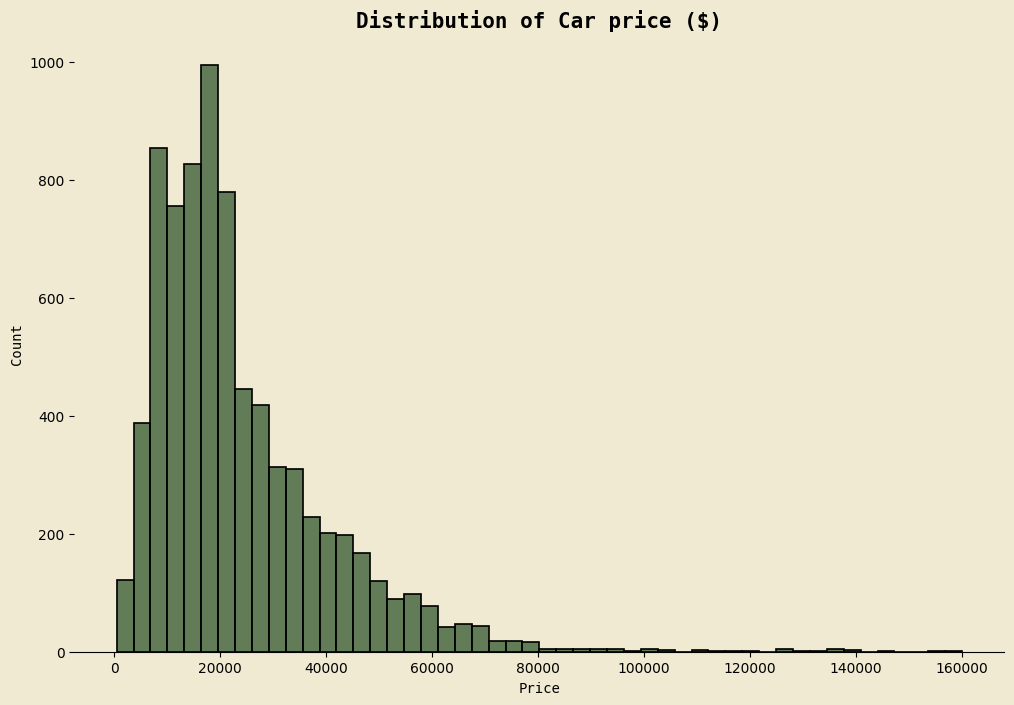

In [8]:
# Distribution of Car Price

fig, ax = plt.subplots(figsize=(12,8))
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)
sns.histplot(data=df, x='price', bins=50, ec='k', lw=3, color=color_3)
for s in ['top','right','left']:
    ax.spines[s].set_visible(False)
    
plt.title("Distribution of Car price ($)", fontsize=15, weight='bold', fontfamily='monospace')
ax.set_xlabel("Price", fontfamily='monospace')
ax.set_ylabel("Count", fontfamily='monospace')
plt.show()

In [9]:
# grouping the car brands to understand our data better

brand_transmission = df.groupby('brand')['transmission'].value_counts(normalize=True).unstack()
brand_transmission_copy = df.groupby('brand')['transmission'].value_counts().unstack()

brand_transmission

transmission,Automatic,Manual,Semi-Auto
brand,,,
audi,0.529637,0.021033,0.449331
bmw,0.377301,0.048057,0.574642
ford,0.155518,0.720736,0.123746
hyundi,0.237454,0.580171,0.182375
merc,0.599343,0.087028,0.313629
skoda,0.116170,0.607535,0.276295
toyota,0.504881,0.390516,0.104603
vauxhall,0.098701,0.890909,0.010390
vw,0.308887,0.368421,0.322692


In [10]:
auto_sr = brand_transmission_copy['Automatic'].sort_values()
manual_sr = brand_transmission_copy['Manual'].sort_values()
semi_sr = brand_transmission_copy['Semi-Auto'].sort_values()

**Brand & Transmission**

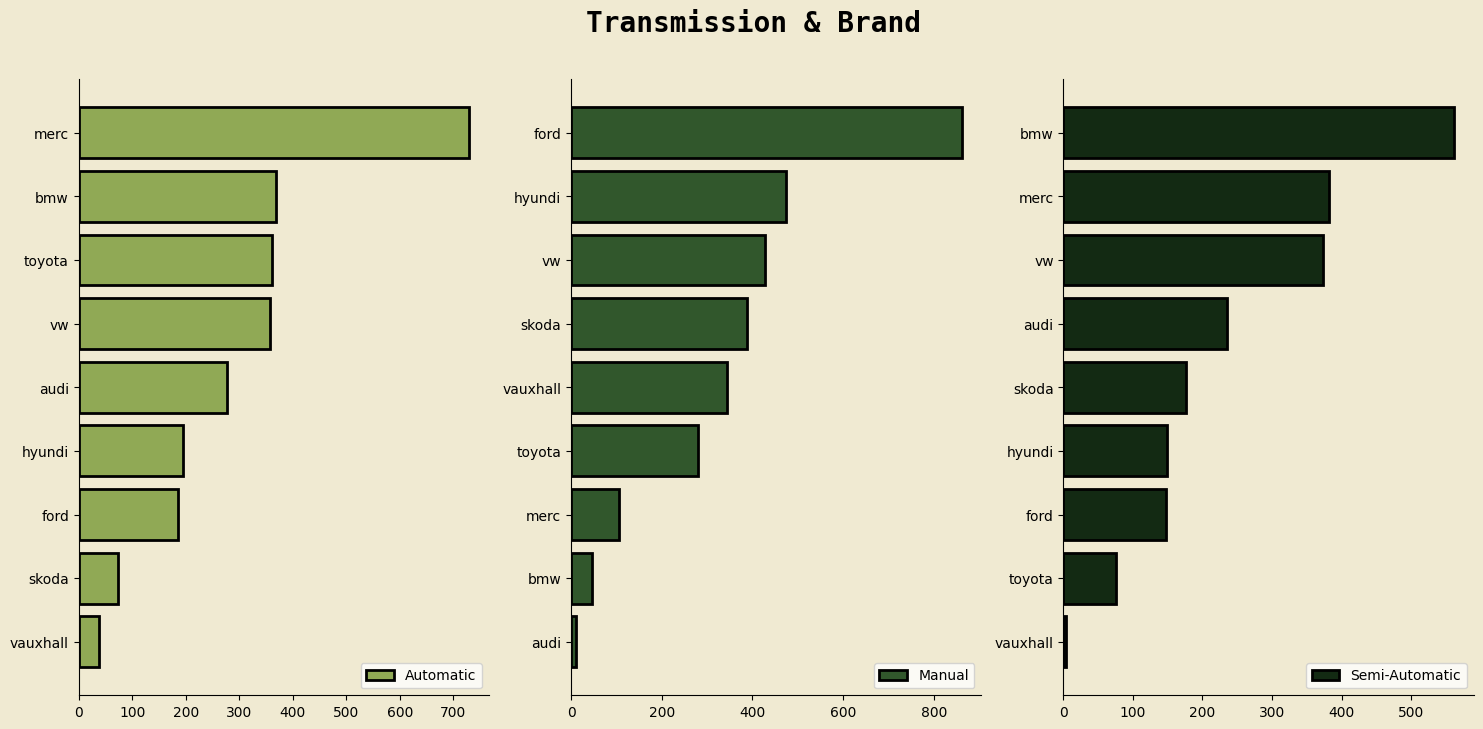

In [11]:
fig, ax = plt.subplots(1,3, figsize=(18,8))
fig.patch.set_facecolor(background_color) # figure background color
ax[0].set_facecolor(background_color)
ax[1].set_facecolor(background_color)
ax[2].set_facecolor(background_color)

ax[0].barh(y=auto_sr.index, width=auto_sr.values, color=color_1, ec='k', lw=2)
ax[1].barh(y=manual_sr.index, width=manual_sr.values, color=color_3, ec='k', lw=2)
ax[2].barh(y=semi_sr.index, width=semi_sr.values, color=color_4, ec='k', lw=2)

ax[0].legend(["Automatic"], loc='lower right')
ax[1].legend(["Manual"], loc='lower right')
ax[2].legend(["Semi-Automatic"], loc='lower right')

for i in range(3):
    for s in ['top','right']:
        ax[i].spines[s].set_visible(False)

fig.text(x=0.5, y=.95, s="Transmission & Brand", fontsize=20, fontfamily='monospace', weight='bold',
         ha='center', va='center')
plt.show()

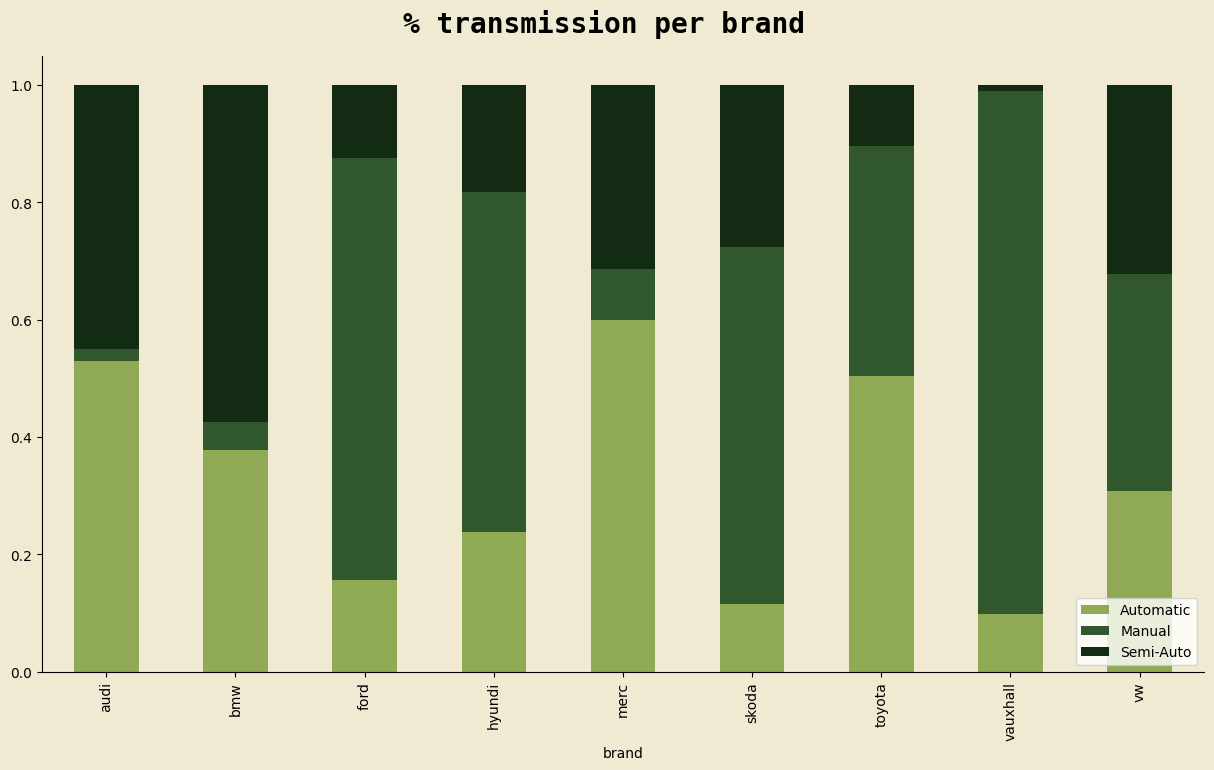

In [12]:
fig, ax = plt.subplots(figsize=(15,8))
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)
brand_transmission.plot(kind='bar', stacked=True, ax=ax, color=[color_1, color_3, color_4])
fig.text(x=0.5, y=.92, s="% transmission per brand", fontsize=20, fontfamily='monospace', weight='bold',
         ha='center', va='center')

for s in ['top','right']:
    ax.spines[s].set_visible(False)

plt.legend(loc='lower right')
plt.show()

Audi is mainly focused on Automatic, Vauxhall - Manual, and bmw are the biggest makers of Semi-Auto cars

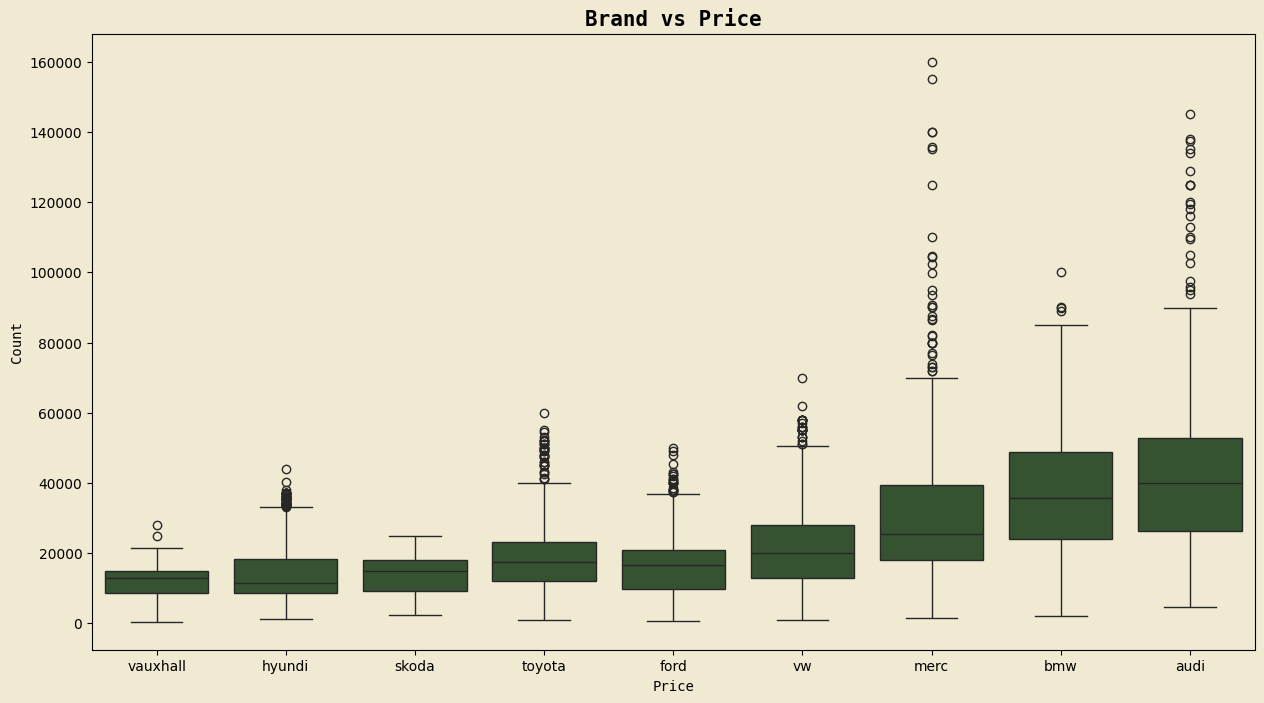

In [13]:
# Brand vs Price

fig, ax = plt.subplots(figsize=(15,8))
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)
sns.boxplot(data=df, x='brand', y='price', order=['vauxhall','hyundi','skoda','toyota','ford','vw','merc','bmw','audi'], color=color_3)

plt.title("Brand vs Price", fontsize=15, weight='bold', fontfamily='monospace')
ax.set_xlabel("Price", fontfamily='monospace')
ax.set_ylabel("Count", fontfamily='monospace')
plt.show()

The previous plot illustrated how Audi are the biggest makers of Automatic cars, and hence their higher price.

Vauxhall focuses largely on Manual, leading the brand to have the lowest price.

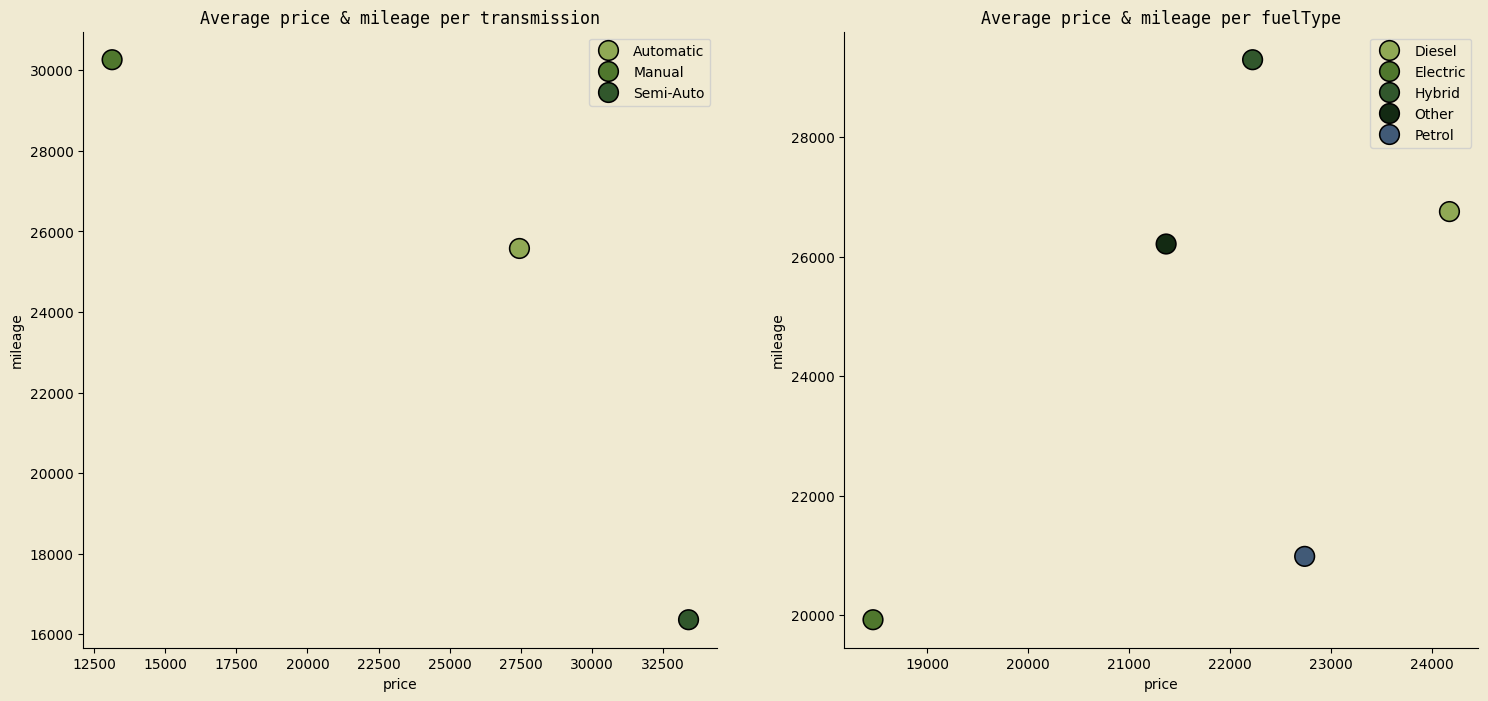

In [14]:

fig, ax = plt.subplots(1,2, figsize=(18,8))
fig.patch.set_facecolor(background_color) # figure background color
ax[0].set_facecolor(background_color)
ax[1].set_facecolor(background_color)

transmission_df = df.groupby('transmission', as_index=False)[['price', 'mileage']].mean()
fuel_df = df.groupby('fuelType', as_index=False)[['price', 'mileage']].mean()

sns.scatterplot(x=transmission_df['price'], y=transmission_df['mileage'], hue=transmission_df['transmission'], ax=ax[0], s=200, ec='k',
                palette=[color_1, color_2, color_3])

sns.scatterplot(x=fuel_df['price'], y=fuel_df['mileage'], hue=fuel_df['fuelType'], ax=ax[1], s=200, ec='k',
                 palette=[color_1, color_2, color_3, color_4, "#415a77"])

for i in range(2):
    for s in ['top','right',]:
        ax[i].spines[s].set_visible(False)

legend_1 = ax[0].legend(loc="best")
legend_1.get_frame().set_facecolor(background_color)
legend_2 = ax[1].legend(loc="best")
legend_2.get_frame().set_facecolor(background_color)

ax[0].set_title("Average price & mileage per transmission", fontfamily='monospace')
ax[1].set_title("Average price & mileage per fuelType", fontfamily='monospace')

plt.show()

Semi-Automatic cars tend to cost more on average, possibly due to their lower mileage.

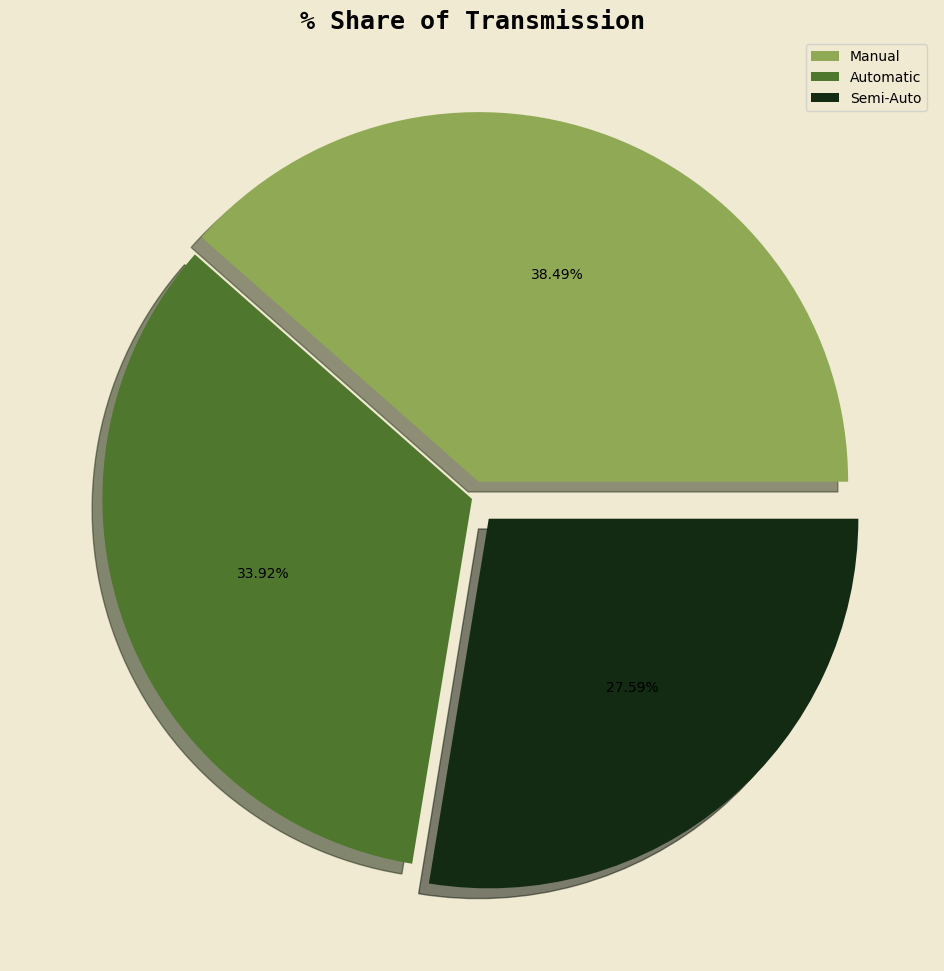

In [15]:
pie_data = df['transmission'].value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(12,12))
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)
ax.pie(pie_data, explode=[0.05,0,0.07], autopct="%.2f%%", shadow=True, colors=[color_1, color_2, color_4])
labels = ["Manual","Automatic","Semi-Auto","Other"]
legend = plt.legend(labels, loc="best")
legend.get_frame().set_facecolor(background_color)
plt.title("% Share of Transmission", fontsize=18, fontfamily='monospace', weight='bold')
plt.show()

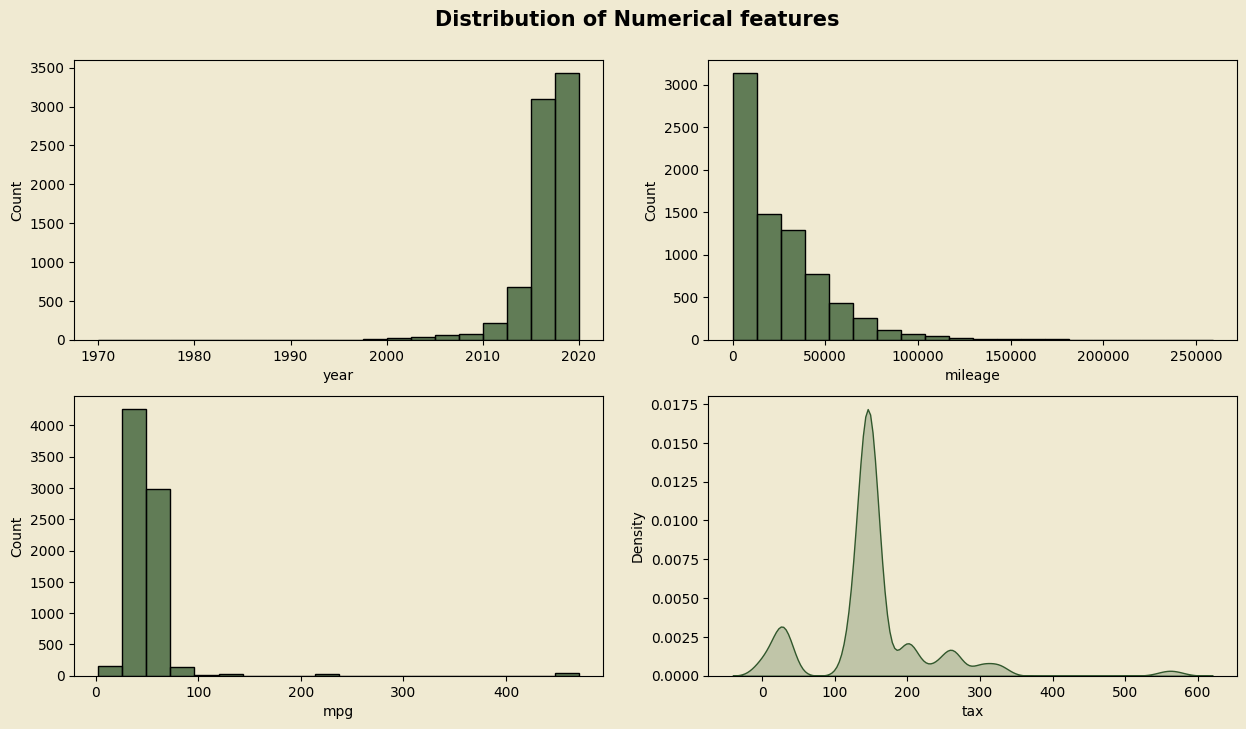

In [16]:
# Distribution of Numerical features

cols = ['year','mileage','mpg']

a, b = 0, 0
fig, ax = plt.subplots(2,2, figsize=(15,8))
fig.patch.set_facecolor(background_color) # figure background color
ax[0,0].set_facecolor(background_color)
ax[0,1].set_facecolor(background_color)
ax[1,0].set_facecolor(background_color)
ax[1,1].set_facecolor(background_color)

for col in cols:
        sns.histplot(df[col], ax=ax[a,b], bins=20, color=color_3)
        b +=1
        if b == 2:
            b = 0
            a +=1
sns.kdeplot(df['tax'], ax=ax[1,1], color=color_3, fill=True)
fig.text(s="Distribution of Numerical features", x=0.5, y=0.93, ha='center', va='center', fontsize=15, weight='bold')
plt.show()

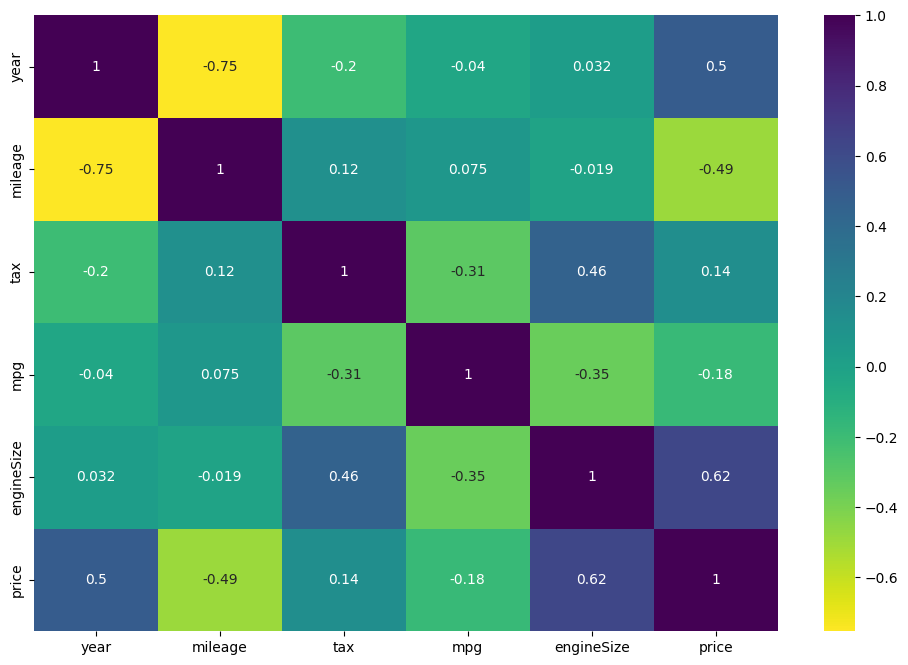

In [17]:
# correlation matrix

plt.figure(figsize=(12,8))

conf_matrix = df.select_dtypes(include=['float','int']).corr()
sns.heatmap(conf_matrix, cmap='viridis_r', annot=True)
plt.show()

Year and mileage are strongly correlated >|0.7| so we have to drop one of them to avoid multi-collinearity

In [18]:
# dropping mileage in the train and test data

df.drop('mileage', axis=1, inplace=True)

## Building the model
**data preprocessing**

In [19]:
# splitting the dataset
train = df.drop("price", axis=1)
target = df['price']

In [20]:
# separating our numerical and categorical features

num_attribs = train.select_dtypes(include=['int','float']).columns
cat_attribs = train.select_dtypes(exclude=['int','float']).columns

In [21]:
train = pd.concat([pd.get_dummies(train[cat_attribs], prefix_sep="", prefix=""), train[num_attribs]], axis=1)

# update cat_attribs
cat_attribs = train.select_dtypes(exclude=['int','float']).columns

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [23]:
# transformer class to handle dataframe selection

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attrib_names):
        self.attrib_names = attrib_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attrib_names]

In [24]:
num_pipeline = Pipeline([
    ('select dataframe', DataFrameSelector(num_attribs)),
    ('standardize', StandardScaler())
])

In [25]:
cat_pipeline = Pipeline([
    ('select dataframe', DataFrameSelector(cat_attribs))
])

In [26]:
# full transformation pipeline
full_pipeline = FeatureUnion(transformer_list = [
    ('numerical', num_pipeline),
    ('categorical', cat_pipeline)
])

In [27]:
X_train_scaled = full_pipeline.fit_transform(X_train)
X_val_scaled = full_pipeline.transform(X_val)

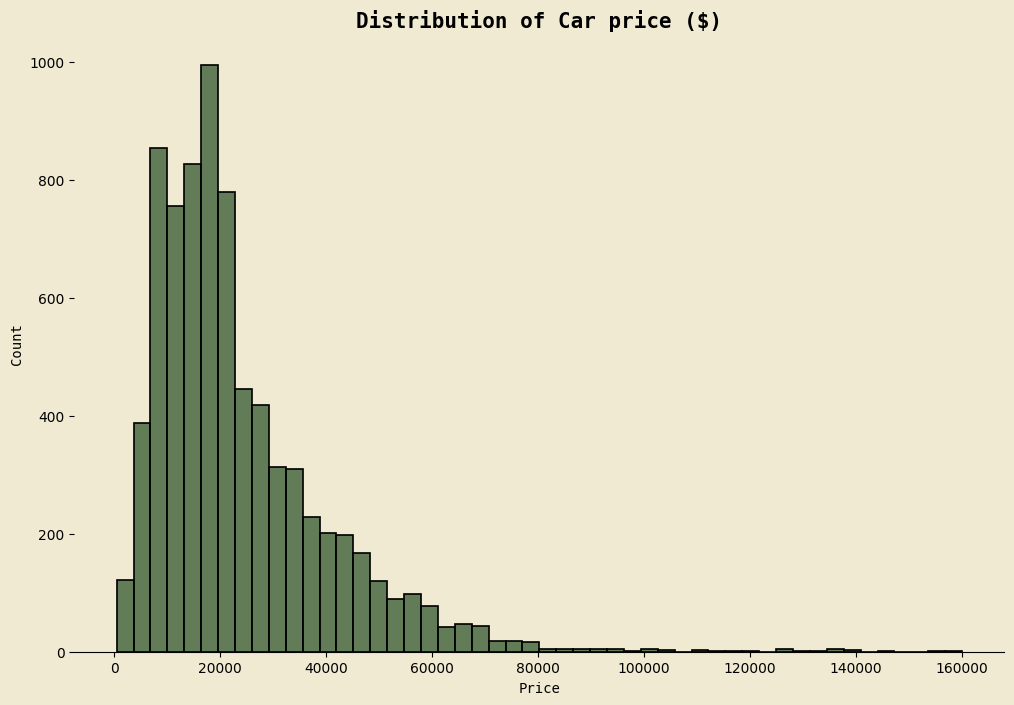

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)
sns.histplot(data=df, x='price', bins=50, ec='k', lw=3, color=color_3)
for s in ['top','right','left']:
    ax.spines[s].set_visible(False)
    
plt.title("Distribution of Car price ($)", fontsize=15, weight='bold', fontfamily='monospace')
ax.set_xlabel("Price", fontfamily='monospace')
ax.set_ylabel("Count", fontfamily='monospace')
plt.show()

our target, i.e car price is right skewed, and is spread over a wide range, so to improve model performance we are going to apply a log transformation. To perform this log transformation, we will use the np.log1p which calculates the natural logarithm of a value (x) +1.

**So why use np.log1p instead of np.log?**<br/>
The main advantage of using np.log1p() is that it provides better numerical stability and avoids potential issues with taking the logarithm of very small values. When you have input values close to zero, taking the logarithm directly with np.log() can result in undefined or inaccurate values. By using np.log1p(), you ensure that the logarithm is calculated accurately and without errors for values close to zero.

In [29]:
# transforming our targets

y_train = np.log1p(y_train)
y_val = y_val

Next we are going to standardize our entire dataset. Standardization is better in this case as we have few outliers in our dataset, and our dataset isn't bound to a specific range. If we had a dataset where we had defined upper and lower bounds like Age [0~99], Normalization would have been a better option.

We will train our models using their base paramters and then see if we can improve their performance by using a voting regressor

In [30]:
# defining the regression models

lin_reg = LinearRegression()
ridge_reg = Ridge(random_state=2)
lasso_reg = Lasso(random_state=2)
rnd_reg = RandomForestRegressor(random_state=2)
svm_reg = SVR()
knn_reg = KNeighborsRegressor()

In [31]:
models = [lin_reg, ridge_reg, lasso_reg, rnd_reg, svm_reg, knn_reg]
mse_dict = {}
msle_dict = {}
r2_scores = {}
predictions = {}

for idx, model in enumerate(models):
    print(f"#{idx+1}. Training {model.__class__.__name__}")
    model.fit(X_train_scaled, y_train)
    pred = np.expm1(model.predict(X_val_scaled))
    predictions[model.__class__.__name__] = pred
    mse_dict[model.__class__.__name__] = np.sqrt(mean_squared_error(y_val, pred))
    msle_dict[model.__class__.__name__] = mean_squared_log_error(y_val, pred)
    msle_dict[model.__class__.__name__] = mean_squared_log_error(y_val, pred)
    r2_scores[model.__class__.__name__] = r2_score(y_val, pred)

#1. Training LinearRegression
#2. Training Ridge
#3. Training Lasso
#4. Training RandomForestRegressor
#5. Training SVR
#6. Training KNeighborsRegressor


In [32]:
results_df = pd.DataFrame([mse_dict, msle_dict, r2_scores])
results_df.insert(0, "metric", ["root mean squared error", "mean squared log error", "R2"])
results_df.set_index("metric", inplace=True)

In [33]:
gmap = np.array([
    [2,2,3,1,2,2],
    [2,2,3,1,2,2],
    [2,2,3,1,2,2]
])

results_df.style.background_gradient(axis=None, gmap=gmap, cmap="Greens_r")

,LinearRegression,Ridge,Lasso,RandomForestRegressor,SVR,KNeighborsRegressor
metric,,,,,,
root mean squared error,4786.356863,4730.297808,16982.454756,3861.302275,3886.521694,4759.009165
mean squared log error,0.024082,0.024019,0.477635,0.018826,0.016981,0.022707
R2,0.915858,0.917818,-0.059259,0.945239,0.944522,0.916817


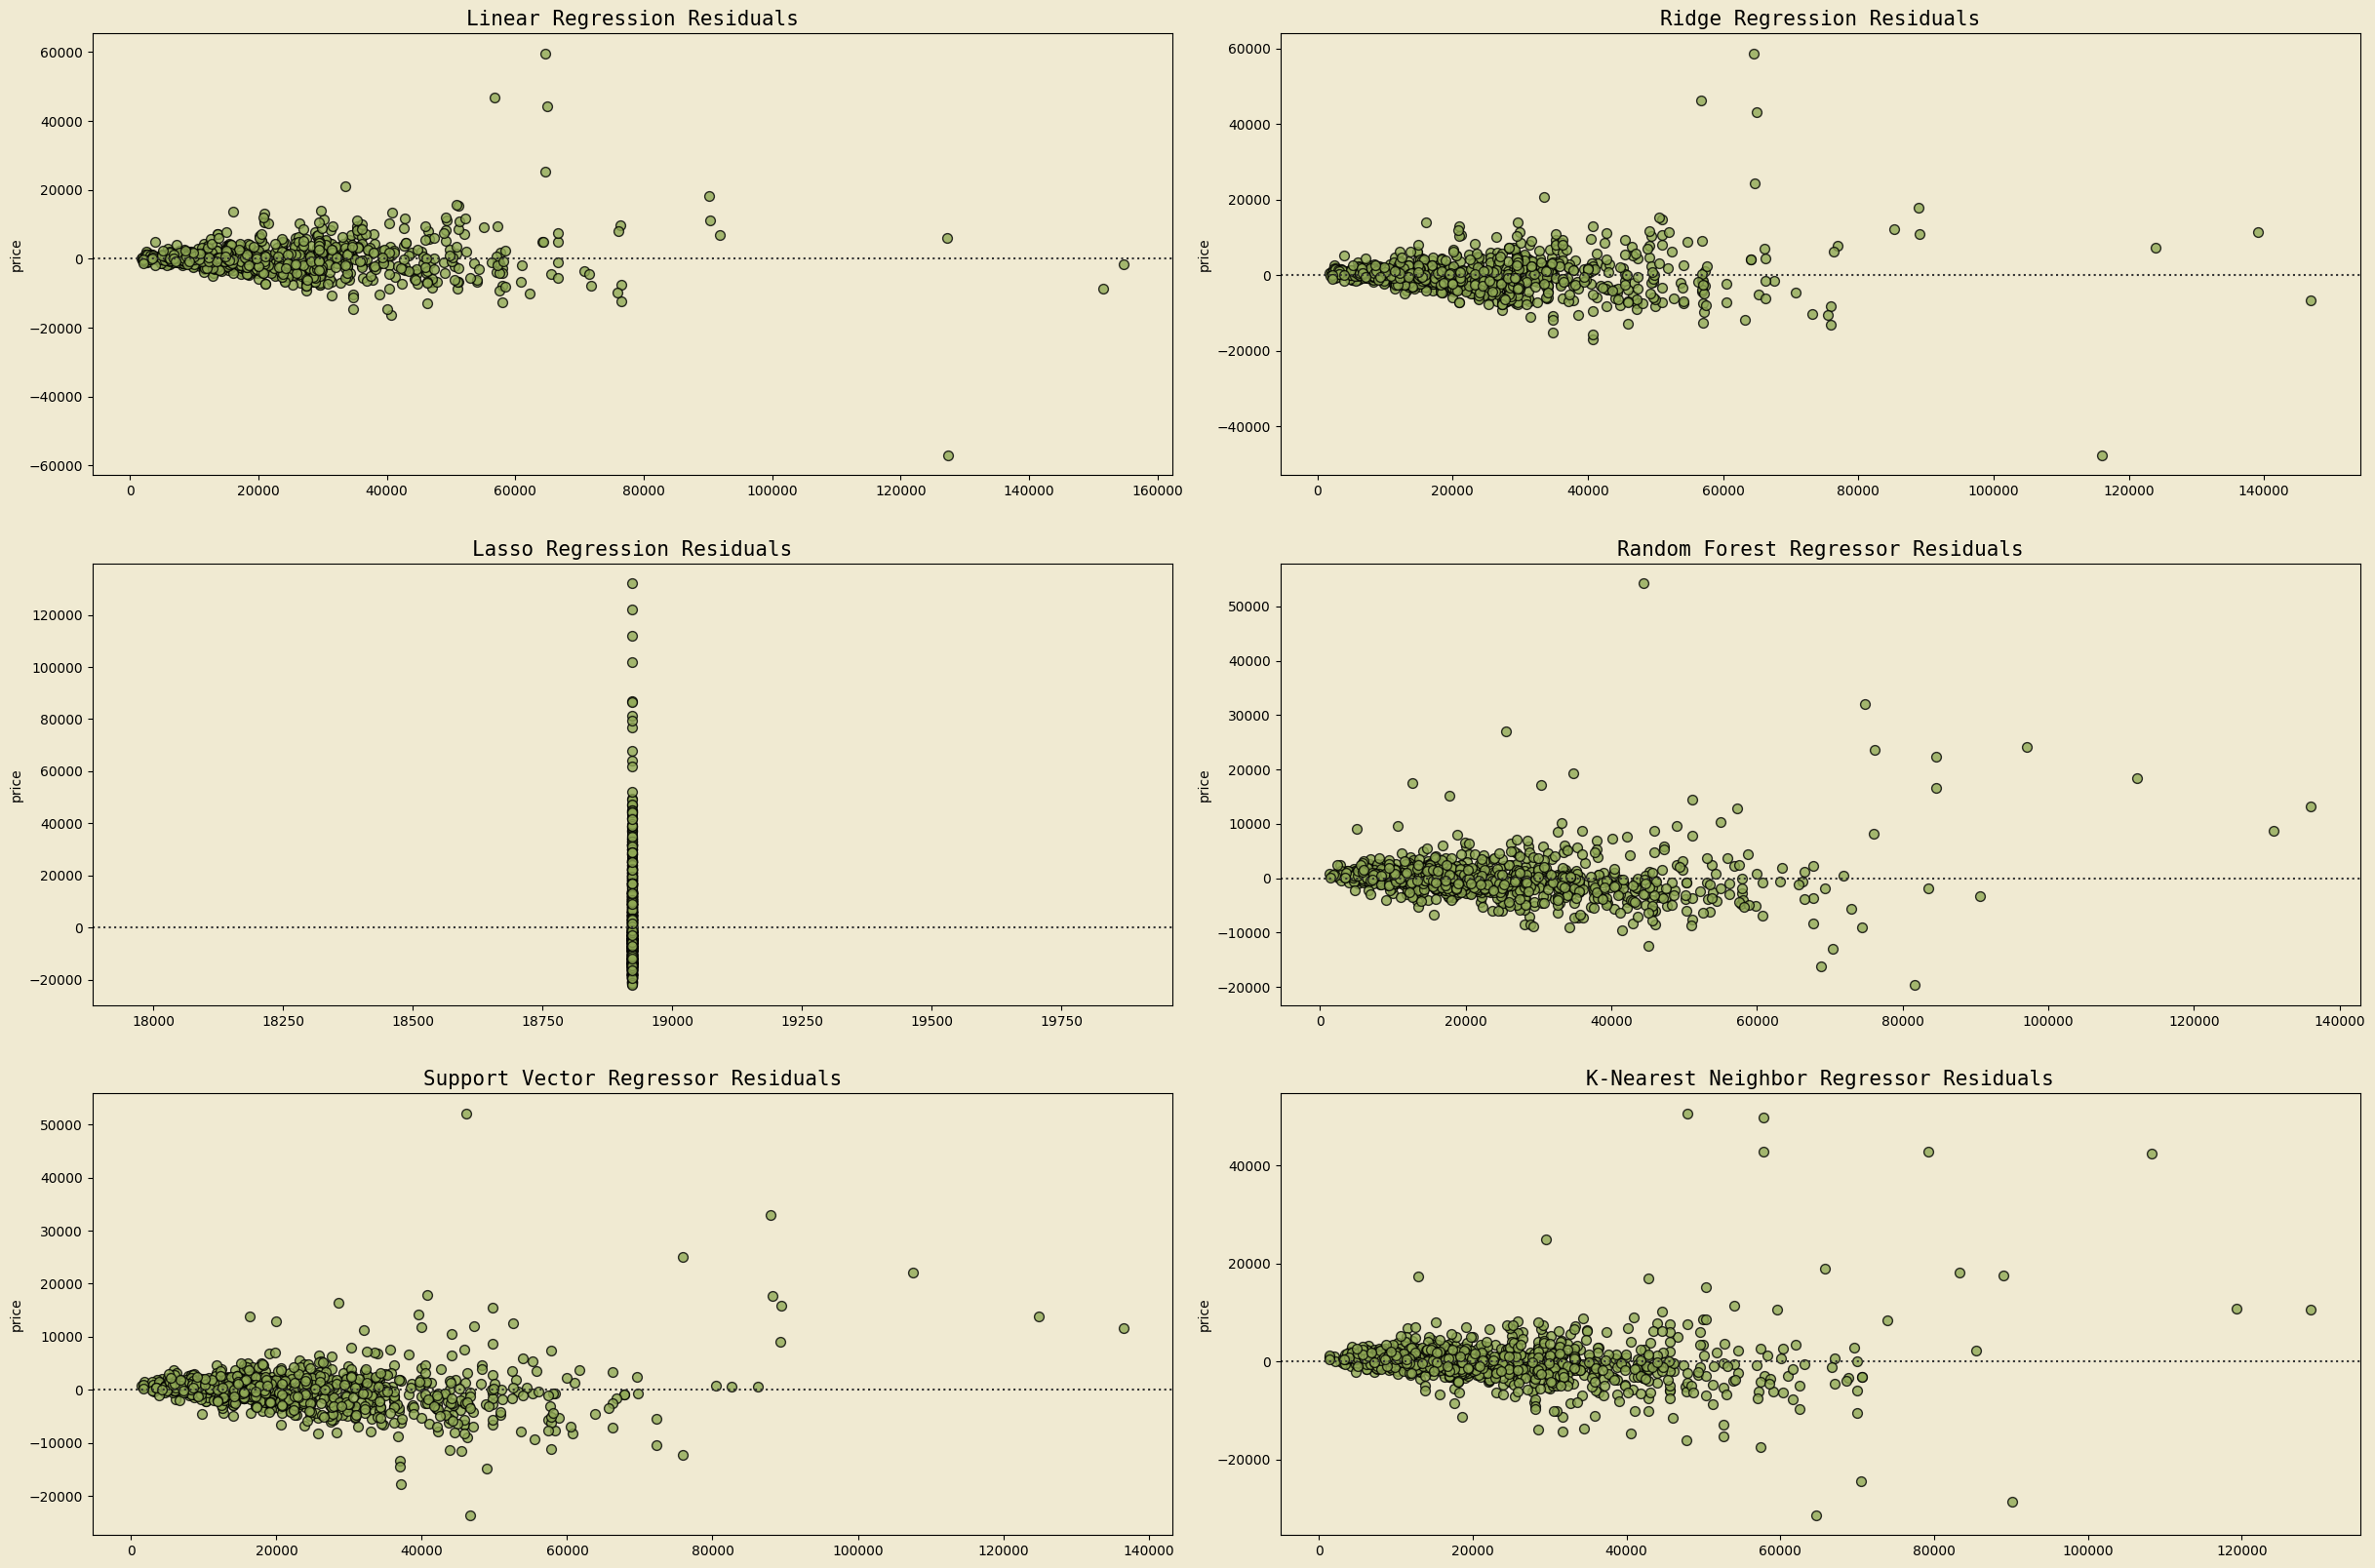

In [34]:
fig, ax = plt.subplots(3,2, figsize=(30,20))
fig.patch.set_facecolor(background_color) # figure background color
ax[0,0].set_facecolor(background_color)
ax[0,1].set_facecolor(background_color)
ax[1,0].set_facecolor(background_color)
ax[1,1].set_facecolor(background_color)
ax[2,0].set_facecolor(background_color)
ax[2,1].set_facecolor(background_color)

sns.residplot(x=predictions['LinearRegression'], y=y_val, ax=ax[0,0], color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})
sns.residplot(x=predictions['Ridge'], y=y_val, ax=ax[0,1], color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})
sns.residplot(x=predictions['Lasso'], y=y_val, ax=ax[1,0], color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})
sns.residplot(x=predictions['RandomForestRegressor'], y=y_val, ax=ax[1,1], color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})
sns.residplot(x=predictions['SVR'], y=y_val, ax=ax[2,0], color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})
sns.residplot(x=predictions['KNeighborsRegressor'], y=y_val, ax=ax[2,1], color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})

ax[0,0].set_title("Linear Regression Residuals", fontfamily="monospace", fontsize=15)
ax[0,1].set_title("Ridge Regression Residuals", fontfamily="monospace", fontsize=15)
ax[1,0].set_title("Lasso Regression Residuals", fontfamily="monospace", fontsize=15)
ax[1,1].set_title("Random Forest Regressor Residuals", fontfamily="monospace", fontsize=15)
ax[2,0].set_title("Support Vector Regressor Residuals", fontfamily="monospace", fontsize=15)
ax[2,1].set_title("K-Nearest Neighbor Regressor Residuals", fontfamily="monospace", fontsize=15)

plt.subplots_adjust(wspace=0.1, hspace=0.2)

All models except the RandomForestRegressor exhibit some degree of heteroschedasticity, with Linear and Ridge models having the most pronounced residuals.

In regression problems, we want our residuals to be homogeneous i.e homoschedasticity, because heteroschedasticity could indicate that the model's predictions are less precise.

Now let's compare each models predictions to the target values

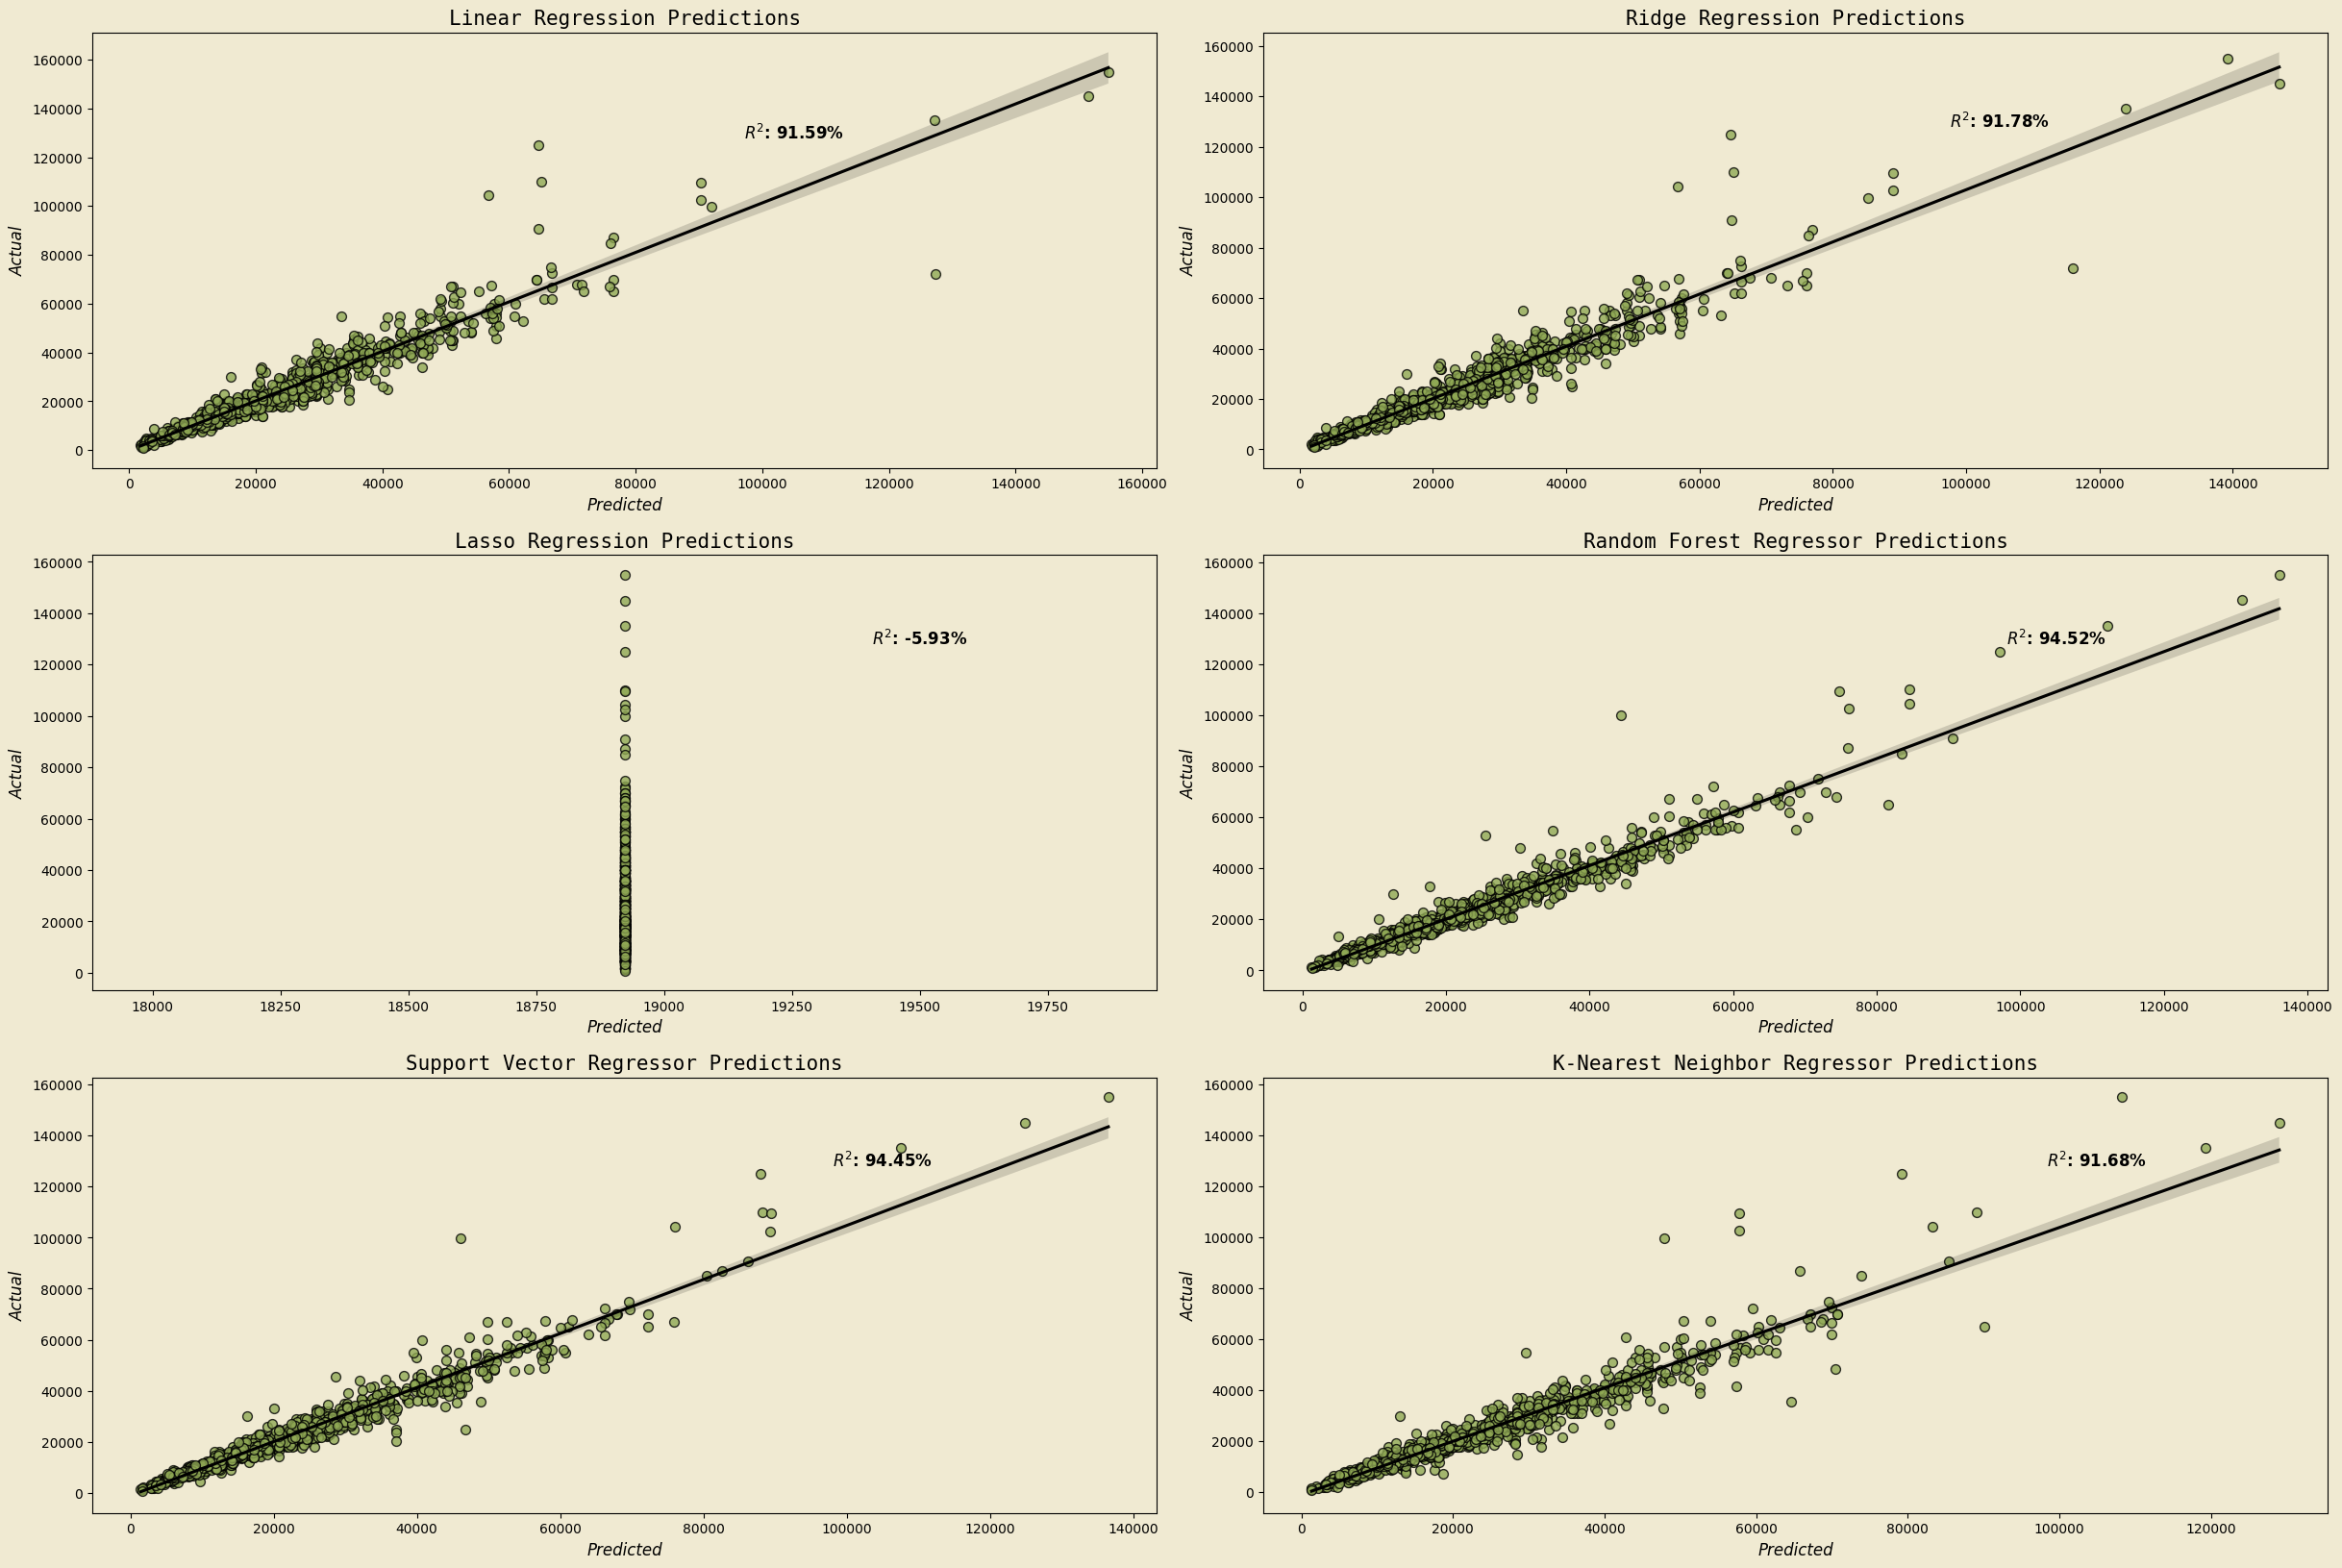

In [35]:
# plotting model predictions vs targets

fig, ax = plt.subplots(3,2, figsize=(30,20))
fig.patch.set_facecolor(background_color) # figure background color
ax[0,0].set_facecolor(background_color)
ax[0,1].set_facecolor(background_color)
ax[1,0].set_facecolor(background_color)
ax[1,1].set_facecolor(background_color)
ax[2,0].set_facecolor(background_color)
ax[2,1].set_facecolor(background_color)

sns.regplot(x=predictions['LinearRegression'], y=y_val, ax=ax[0,0], color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})
sns.regplot(x=predictions['Ridge'], y=y_val, ax=ax[0,1], color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})
sns.regplot(x=predictions['Lasso'], y=y_val, ax=ax[1,0], color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})
sns.regplot(x=predictions['RandomForestRegressor'], y=y_val, ax=ax[1,1], color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})
sns.regplot(x=predictions['SVR'], y=y_val, ax=ax[2,0], color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})
sns.regplot(x=predictions['KNeighborsRegressor'], y=y_val, ax=ax[2,1], color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})

ax[0,0].set_title("Linear Regression Predictions", fontfamily="monospace", fontsize=15)
ax[0,1].set_title("Ridge Regression Predictions", fontfamily="monospace", fontsize=15)
ax[1,0].set_title("Lasso Regression Predictions", fontfamily="monospace", fontsize=15)
ax[1,1].set_title("Random Forest Regressor Predictions", fontfamily="monospace", fontsize=15)
ax[2,0].set_title("Support Vector Regressor Predictions", fontfamily="monospace", fontsize=15)
ax[2,1].set_title("K-Nearest Neighbor Regressor Predictions", fontfamily="monospace", fontsize=15)

ax[0,0].set_xlabel("Predicted", fontsize=12, style='italic')
ax[0,1].set_xlabel("Predicted", fontsize=12, style='italic')
ax[1,0].set_xlabel("Predicted", fontsize=12, style='italic')
ax[1,1].set_xlabel("Predicted", fontsize=12, style='italic')
ax[2,0].set_xlabel("Predicted", fontsize=12, style='italic')
ax[2,1].set_xlabel("Predicted", fontsize=12, style='italic')

ax[0,0].set_ylabel("Actual", fontsize=12, style='italic')
ax[0,1].set_ylabel("Actual", fontsize=12, style='italic')
ax[1,0].set_ylabel("Actual", fontsize=12, style='italic')
ax[1,1].set_ylabel("Actual", fontsize=12, style='italic')
ax[2,0].set_ylabel("Actual", fontsize=12, style='italic')
ax[2,1].set_ylabel("Actual", fontsize=12, style='italic')

ax[0,0].annotate(xy=(105000,130000), text=f"$R^2$: {r2_scores[results_df.columns[0]]:.2%}",
                 fontsize=12, ha='center', va='center', weight='bold')
ax[0,1].annotate(xy=(105000,130000), text=f"$R^2$: {r2_scores[results_df.columns[1]]:.2%}",
                 fontsize=12, ha='center', va='center', weight='bold')
ax[1,0].annotate(xy=(19500,130000), text=f"$R^2$: {r2_scores[results_df.columns[2]]:.2%}",
                 fontsize=12, ha='center', va='center', weight='bold')
ax[1,1].annotate(xy=(105000,130000), text=f"$R^2$: {r2_scores[results_df.columns[3]]:.2%}",
                 fontsize=12, ha='center', va='center', weight='bold')
ax[2,0].annotate(xy=(105000,130000), text=f"$R^2$: {r2_scores[results_df.columns[4]]:.2%}",
                 fontsize=12, ha='center', va='center', weight='bold')
ax[2,1].annotate(xy=(105000,130000), text=f"$R^2$: {r2_scores[results_df.columns[5]]:.2%}",
                 fontsize=12, ha='center', va='center', weight='bold')

plt.subplots_adjust(wspace=0.1, hspace=0.2)

The $R^2$ for Lasso regression was -ve because our datasets are very sparse and Lasso penalizes features with 'little importance' so basically it ends up learning nothing.

Since the remaining regressors performed well, we will train a voting regressor to see if we can improve upon their accuracies.

In [36]:
# we'll set different weights for the estimators according to their individual accuracies

vot_reg = VotingRegressor([
    ('LinearRegression', lin_reg),
    ('Knn', knn_reg),
    ('Ridge', ridge_reg),
    ('RandomForest', rnd_reg),
    ('SVR', svm_reg)
], weights=[0.05, 0.05, 0.05, 0.5, 0.35])

In [37]:
# training the voting regressor

vot_reg.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('LinearRegression', LinearRegression()),
                            ('Knn', KNeighborsRegressor()),
                            ('Ridge', Ridge(random_state=2)),
                            ('RandomForest',
                             RandomForestRegressor(random_state=2)),
                            ('SVR', SVR())],
                weights=[0.05, 0.05, 0.05, 0.5, 0.35])

In [38]:
vot_preds = np.expm1(vot_reg.predict(X_val_scaled))
print(f"Voting Regressor R2 score: {r2_score(y_val, vot_preds):.2%}")

Voting Regressor R2 score: 95.03%


**Test set**

Now we can test our model on the test set. However, before we begin, we need to load the test labels so we can compare our predictions.

In [39]:
# transforming the test dataset using the scaler we used earlier

X_test_scaled = full_pipeline.transform(X_test)

In [40]:
# making predictions

test_pred = vot_reg.predict(X_test_scaled)
test_pred = np.expm1(test_pred)

In [41]:
final_df = pd.DataFrame(
    {'Actual price':y_test, "Predicted price": test_pred}
)
final_df['Predicted price'] = final_df['Predicted price'].apply(lambda x: round(x,2))
final_df

,Actual price,Predicted price
683,51000,45419.07
1964,15990,15790.02
4149,19800,18308.65
3378,18390,17769.66
4500,9990,11351.95
...,...,...
3450,49589,41568.62
5982,22000,22001.88
1192,20699,21054.38
2249,22991,24907.02


In [42]:
# Test set metrics

print(f"Root-mean-squared-error: {np.sqrt(mean_squared_error(y_test, test_pred)):,.2f}")
print(f"Mean-squared-log-error: {mean_squared_log_error(y_test, test_pred):.01}")
print(f"R2 accuracy: {r2_score(y_test, test_pred):.2%}")

Root-mean-squared-error: 3,623.63
Mean-squared-log-error: 0.02
R2 accuracy: 95.61%


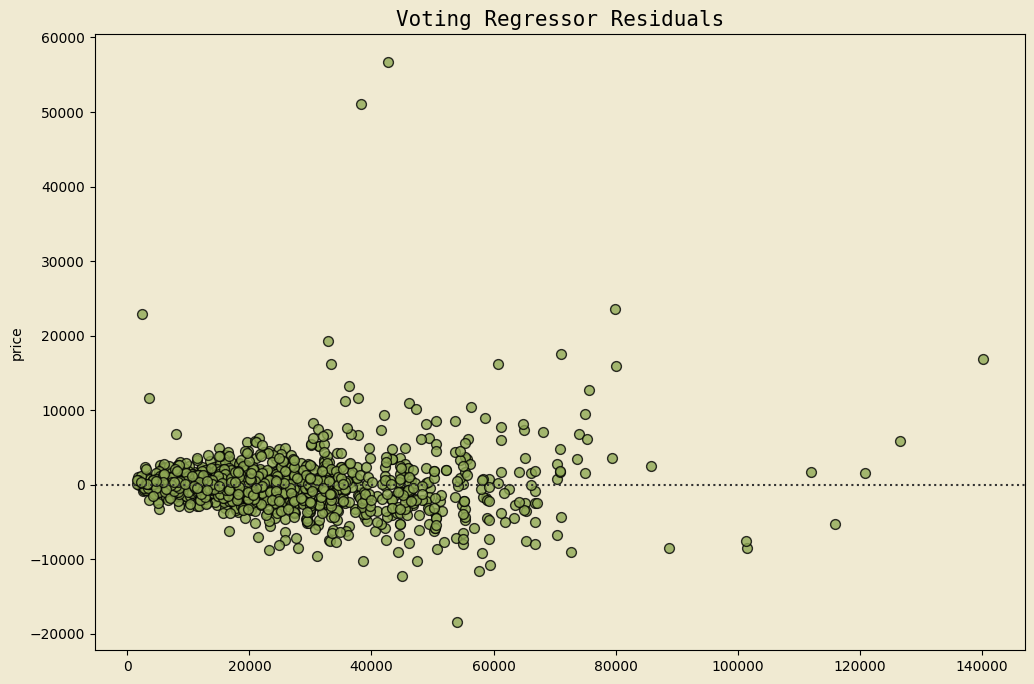

In [43]:
# voting regressor residuals

fig, ax = plt.subplots(figsize=(12,8))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

sns.residplot(x=test_pred, y=y_test, color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k', 'linewidth':5, 'linestyle':'o'})

ax.set_title("Voting Regressor Residuals", fontfamily="monospace", fontsize=15)

plt.show()

The residual plot for the voting regressor exhibits homoschedasticity, which indicates that the model's predictions are precise.

This is an improvement on the residual plots of the individual models trained earlier.

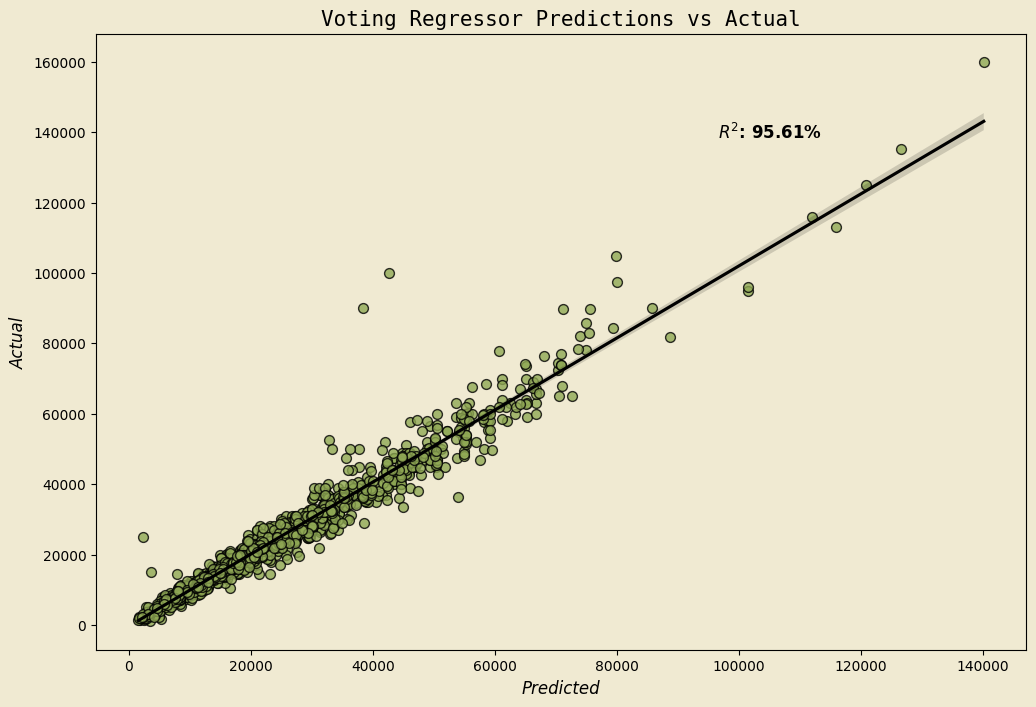

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)

sns.regplot(x=test_pred, y=y_test, color=color_1, scatter_kws={'edgecolor':'k', 's':50}, 
            line_kws={'color':'k'})

ax.set_title("Voting Regressor Predictions vs Actual", fontfamily="monospace", fontsize=15)

ax.set_xlabel("Predicted", fontsize=12, style='italic')

ax.set_ylabel("Actual", fontsize=12, style='italic')

ax.annotate(xy=(105000,140000), text=f"$R^2$: {r2_score(y_test, test_pred):.2%}",
                 fontsize=12, ha='center', va='center', weight='bold')
plt.show()